In [84]:
# we need to deal with those with limited pbd info
# 'GAL4_YEAST_Shendure2015-SEL_C_40h', 7uik starts with 8
import os
def filter_entry(entry,lab_func):

    dir = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{entry}_old'
    import pandas as pd
    data = pd.read_csv(f'{dir}/data.csv')
    # drop those with int(mutant[1:-1])<8, return mask first
    mask = data['mutant'].apply(lab_func)
    data = data[mask].reset_index(drop=True)
    
    save_path = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{entry}'
    # mkdir -p save_path
    os.makedirs(save_path, exist_ok=True)
    print(save_path)
    data.to_csv(f'{save_path}/data.csv', index=False)
    # read fasta
    fasta_file = f'{dir}/seqs.fasta'
    from Bio import SeqIO
    def read_fasta(filename, return_ids=False):
        records = SeqIO.parse(filename, 'fasta')
        seqs = list()
        ids = list()
        for record in records:
            seqs.append(str(record.seq))
            ids.append(str(record.id))
        if return_ids:
            return seqs, ids
        else:
            return seqs
    fasta = read_fasta(fasta_file)
    fasta = [fasta[i] for i in range(len(fasta)) if mask[i]]
    # save fasta and ids
    with open(f'{save_path}/seqs.fasta', 'w') as f:
        for i in range(len(fasta)):
            f.write(f'>id_{i}\n{fasta[i]}\n')
    # also save seqs to seqs.txt
    with open(f'{save_path}/seqs.txt', 'w') as f:
        for i in range(len(fasta)):
            f.write(f'{fasta[i]}\n')
# filter_entry('GAL4_YEAST_Shendure2015-SEL_C_40h',lambda x: int(x[1:-1])>=8)
filter_entry('HSP82_YEAST_Bolon2016-selection_coefficient',lambda x: int(x[1:-1])<=214 if (x != 'WT') else False)

/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/HSP82_YEAST_Bolon2016-selection_coefficient


In [85]:
import pandas as pd
label_proteingym_map = {
    'BG_STRSQ_Abate2015-enrichment':'Q59976_STRSQ_Romero_2015',
    'BLAT_ECOLX_Ranganathan2015-2500': 'BLAT_ECOLX_Stiffler_2015',
    'BLAT_ECOLX_Ostermeier2014-linear':'BLAT_ECOLX_Firnberg_2014',
    'BLAT_ECOLX_Palzkill2012-ddG_stat':'BLAT_ECOLX_Deng_2012',
    'BLAT_ECOLX_Tenaillon2013-singles-MIC_score':'BLAT_ECOLX_Jacquier_2013',
    'DLG4_RAT_Ranganathan2012-CRIPT':'DLG4_RAT_McLaughlin_2012', # pdz
    'GAL4_YEAST_Shendure2015-SEL_C_40h':'GAL4_YEAST_Kitzman_2015',
    'HSP82_YEAST_Bolon2016-selection_coefficient': 'HSP82_YEAST_Mishra_2016',
    'KKA2_KLEPN_Mikkelsen2014-Kan18_avg':'KKA2_KLEPN_Melnikov_2014',
    'RL401_YEAST_Bolon2013-selection_coefficient':'RL40A_YEAST_Roscoe_2013',
    'RL401_YEAST_Bolon2014-react_rel':'RL40A_YEAST_Roscoe_2014',
    'YAP1_HUMAN_Fields2012-singles-linear':'YAP1_HUMAN_Araya_2012'
    
    
    
}

    # 'BRCA1_HUMAN_Fields2015-e3': ?
    # 'GFP_AEQVI_Sarkisyan2016': 'GFP_AEQVI_Sarkisyan_2016'
    # 'MTH3_HAEAESTABILIZED_Tawfik2015-Wrel_G17_filtered': 'MTH3_HAEAE_RockahShmuel_2015'
    #''PABP_YEAST_Fields2013-linear':'PABP_YEAST_Melamed_2013'
    # 'POLG_HCVJF_Sun2014-fitness':'POLG_HCVJF_Qi_2014'
    # 'UBE4B_MOUSE_Klevit2013-nscor_log2_ratio':'UBE4B_MOUSE_Starita_2013'

dataset_score = {}
for label_name,proteingym_name in label_proteingym_map.items():
    proteingym_ground_truth_file = f'/work/commons/proteingym/DMS_ProteinGym_substitutions/{proteingym_name}.csv'
    
    models = ['ESM1b','EVmutation','DeepSequence','UniRep_evotuned']
    value_name = ['esm1b_t33_650M_UR50S','prediction_epistatic','evol_indices_ensemble','Unirep_score']
    value_name = dict(zip(models,value_name))
    models_dict = {}
    for model in models:
        proteingym_model_file = f'/work/commons/proteingym/zero_shot_substitutions_scores/{model}/{proteingym_name}.csv'
        proteingym_model = pd.read_csv(proteingym_model_file)
        models_dict[model] = proteingym_model

    label_file = f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/data/{label_name}/data.csv'
    import pandas as pd
    proteingym_gt_file = pd.read_csv(proteingym_ground_truth_file)
    label = pd.read_csv(label_file)
    scores = dict(zip(models,[[] for i in range(len(models))]))
    for i, row in label.iterrows():
        
        mutant_key = 'mutant'
        # print(row[mutant_key])
        if row[mutant_key] == 'WT':
            for model in models:
                scores[model].append(0)
            continue

        if label_name in ['DLG4_RAT_Ranganathan2012-CRIPT'] and row[mutant_key] not in proteingym_gt_file[mutant_key].values:
            print(row[mutant_key])
            for model in models:
                scores[model].append(0)
            continue
        assert row[mutant_key] in proteingym_gt_file[mutant_key].values
        idx = proteingym_gt_file[proteingym_gt_file[mutant_key] == row[mutant_key]].index[0]
        # check mutated sequence
        assert row[mutant_key] in proteingym_gt_file[mutant_key][idx]
        
        for model in models:
            # print(model)
            proteingym_model = models_dict[model]
            value = value_name[model]
            if model is not 'UniRep_evotuned':
                model_score = proteingym_model[proteingym_model[mutant_key] == row[mutant_key]][value]
            else:
                model_score = proteingym_model[proteingym_model['mutated_sequence'] == proteingym_gt_file['mutated_sequence'][idx]][value]
            scores[model].append(model_score.values[0])
    dataset_score[label_name] = scores

P311A


In [95]:

key = 'YAP1_HUMAN_Fields2012-singles-linear'
model_dir = dict(zip(models,['esm','ev','DeepSequence','eUniRep']))
import os
for model in models:
    print(model)
    print(len(dataset_score[key][model]))
    pll_values = dataset_score[key][model]

    # 生成相应的id
    ids = [f'id_{i}' for i in range(len(pll_values))]

    # 创建DataFrame
    df = pd.DataFrame({'pll': pll_values}, index=ids)

    # 将结果写入CSV文件
    #mkdir -p inference/{key}/esm
    os.makedirs(f'inference/{key}/{model_dir[model]}', exist_ok=True)
    df.to_csv(f'inference/{key}/{model_dir[model]}/pll.csv', index=True)

ESM1b
319
EVmutation
319
DeepSequence
319
UniRep_evotuned
319


In [96]:

import pandas as pd
# key = 'BG_STRSQ_Abate2015-enrichment'
for key in ['BG_STRSQ_Abate2015-enrichment']:
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/{key}/results.csv')

    # df_ =pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/BLAT_ECOLX_Ranganathan2015-2500/results_BLAT_ECOLX_Ranganathan2015-2500.csv')
    CORE_PREDICTORS = [
        'onehot',
        'ev+onehot', 
        'gesm+onehot', 
        'eunirep_ll+onehot',
        'vae+onehot', 
        'ev+onehot+ddg', 
        'gesm+onehot+ddg', 
        'eunirep_ll+onehot+ddg',
        'vae+onehot+ddg'
    ]
    for model in CORE_PREDICTORS:
        print(model, df_[df_.predictor==model].spearman.mean())

onehot 0.6258499999999999
ev+onehot 0.6882049999999998
gesm+onehot 0.6781000000000001
eunirep_ll+onehot 0.6402549999999999
vae+onehot 0.7043699999999999
ev+onehot+ddg 0.720545
gesm+onehot+ddg 0.7010500000000001
eunirep_ll+onehot+ddg 0.69058
vae+onehot+ddg 0.7289950000000001


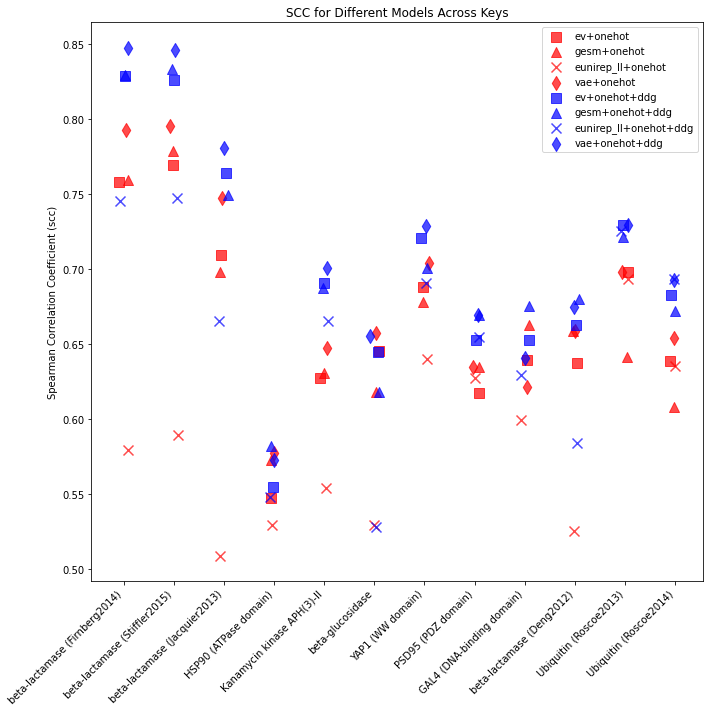

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = [
    'BLAT_ECOLX_Ostermeier2014-linear',
    'BLAT_ECOLX_Ranganathan2015-2500',
    'BLAT_ECOLX_Tenaillon2013-singles-MIC_score',
    'HSP82_YEAST_Bolon2016-selection_coefficient',
    'KKA2_KLEPN_Mikkelsen2014-Kan18_avg',
    'BG_STRSQ_Abate2015-enrichment',
    'YAP1_HUMAN_Fields2012-singles-linear',
    'DLG4_RAT_Ranganathan2012-CRIPT',
    'GAL4_YEAST_Shendure2015-SEL_C_40h',
    'BLAT_ECOLX_Palzkill2012-ddG_stat',
    'RL401_YEAST_Bolon2013-selection_coefficient',
    'RL401_YEAST_Bolon2014-react_rel',
    




]

# 按照图中的顺序调整后的 labels 列表
labels = [
    'beta-lactamase (Firnberg2014)',
    'beta-lactamase (Stiffler2015)',
    'beta-lactamase (Jacquier2013)',
    'HSP90 (ATPase domain)',
    'Kanamycin kinase APH(3)-II',
    'beta-glucosidase',
    'YAP1 (WW domain)',
    'PSD95 (PDZ domain)',
    'GAL4 (DNA-binding domain)',
    'beta-lactamase (Deng2012)',
    'Ubiquitin (Roscoe2013)',
    'Ubiquitin (Roscoe2014)',
    



]

# 定义模型和颜色、形状
CORE_PREDICTORS = [
    # 'onehot',
    'ev+onehot', 
    'gesm+onehot', 
    'eunirep_ll+onehot',
    'vae+onehot', 
    'ev+onehot+ddg', 
    'gesm+onehot+ddg', 
    'eunirep_ll+onehot+ddg',
    'vae+onehot+ddg'
]

# 模型与颜色映射
colors = {
    'onehot': 'gray',
    'ev+onehot': 'red',
    'gesm+onehot': 'red',
    'eunirep_ll+onehot': 'red',
    'vae+onehot': 'red',
    'ev+onehot+ddg': 'blue',
    'gesm+onehot+ddg': 'blue',
    'eunirep_ll+onehot+ddg': 'blue',
    'vae+onehot+ddg': 'blue'
}

# 模型与形状映射
shapes = {
    'onehot': 'o',
    'ev+onehot': 's',    # 方形
    'gesm+onehot': '^',
    'eunirep_ll+onehot': 'x',
    'vae+onehot': 'd',
    'ev+onehot+ddg': 's',  # 方形
    'gesm+onehot+ddg': '^',
    'eunirep_ll+onehot+ddg': 'x',
    'vae+onehot+ddg': 'd'
}

# 绘图
plt.figure(figsize=(10, 10))

# 设置透明度和偏移量（jitter）的幅度
alpha_value = 0.7  # 设置透明度
jitter_strength = 0.1  # 设置交错幅度

# 遍历 keys
for i, key in enumerate(files):
    df_ = pd.read_csv(f'/nethome/zli3161/DATA-nash/combining-evolutionary-and-assay-labelled-data/results/{key}/results.csv')
    
    # 遍历模型
    for model in CORE_PREDICTORS:
        # 获取模型的 spearman 平均值
        mean_scc = df_[df_.predictor == model].spearman.mean()
        
        # 在 x 轴上添加 jitter（微小的偏移）来避免重叠
        jittered_x = i + np.random.uniform(-jitter_strength, jitter_strength)
        
        # 在图中绘制点，设置透明度 alpha
        plt.scatter(jittered_x, mean_scc, color=colors[model], marker=shapes[model], 
                    label=model if i == 0 else "", s=100, alpha=alpha_value)

# 设置图形的轴和标题
plt.xticks(ticks=np.arange(len(files)), labels=labels, rotation=45, ha='right')
plt.ylabel('Spearman Correlation Coefficient (scc)')
plt.title('SCC for Different Models Across Keys')

# 添加图例（去除重复图例项）
handles, legend_labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(legend_labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()
